# 1. Giới thiệu

---------------------------------------------------------------

## a. Khai báo thư viện

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set()
pd.options.display.max_columns = 30

# 2. Load và xem dữ liệu

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/shineonkai/exdataset/master/beerRecipeData.csv',  encoding = 'latin1')
df.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


**Đếm số lượng dữ liệu tổng và lượng dữ liệu ở cột Style**

In [0]:
print('Data set shape:{}'.format(df.shape))
print('Unique styles:{}'.format(df['Style'].nunique()))

Data set shape:(73861, 23)
Unique styles:175


## a. Giá trị missing

**Biểu đồ thể hiện giá trị missing**

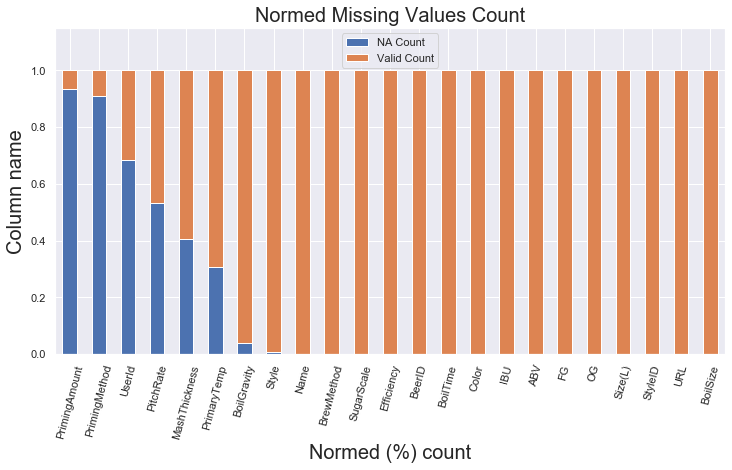

In [0]:
df_missing = df.copy()
df_missing = df_missing.T
true = df_missing.isnull().sum(axis = 1)
false = (len(df_missing.columns) - true)
df_missing['Valid Count'] = false / len(df_missing.columns)
df_missing['NA Count'] = true / len(df_missing.columns)

df_missing[['NA Count', 'Valid Count']].sort_values('NA Count', ascending=False).plot(kind = 'bar', stacked = True, figsize = (12,6))

#theme
plt.legend(loc = 9)
plt.ylim(0, 1.15)
plt.title('Normed Missing Values Count', fontsize = 20)
plt.xlabel('Normed (%) count', fontsize=20)
plt.ylabel('Column name', fontsize=20)
plt.xticks(rotation=75)
plt.show()

**Có 7 cột bị khuyết giá trị**

*15 Cột* **không bị khuyết giá trị** *=> Tuyệt vời để phân tích*

**Có 2 cột (*PrimingAmount, PrimingMethod*) bị khuyết tới gần 90% giá trị**

# 3. Những Style phổ biến nhất

**Loại bỏ các giá trị null ở cột Style**

In [0]:
df = df[pd.notnull(df['Style'])]

## a. Phong cách bia tự chế phổ biến nhất, theo công thức bia là gì?

**% số lượng bia(BeerID) theo từng phong cách(Style)**

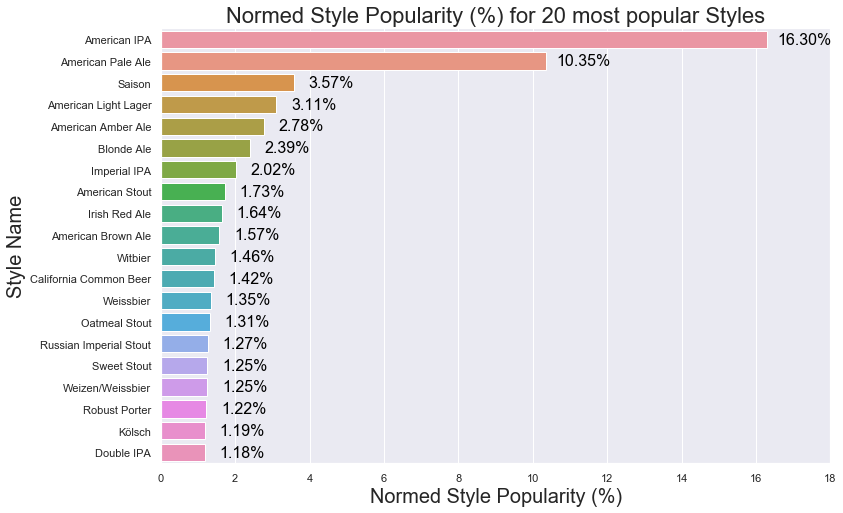

In [0]:
gb_style = df.groupby(['Style']).count().sort_values(['BeerID'], ascending=False).reset_index()[:20]
gb_style['BeerID'] = (gb_style['BeerID'] / len(df)) * 100

plt.figure(figsize=(12,8))
g = sns.barplot(x=gb_style['BeerID'], y=gb_style['Style'], orient='h')
plt.title('Normed Style Popularity (%) for 20 most popular Styles', fontsize=22)
plt.ylabel('Style Name', fontsize=20)
plt.xlabel('Normed Style Popularity (%)', fontsize=20)

plt.xlim(0,18)

for index, row in gb_style.iterrows():
    g.text(y=index+0.2,x=row['BeerID']+1,s='{:.2f}%'.format(row['BeerID']),
           color='black', ha="center", fontsize=16)

plt.show()

Ta có thể thấy có 2 phong cách trên 10% là: **American IPA(~16%)** và **American Pale Ale(~10%)**

## b. Phong cách chung phổ biến nhất?

**Phong cách chung có những loại nào?**

**Phân loại lại và vẽ biểu đồ**

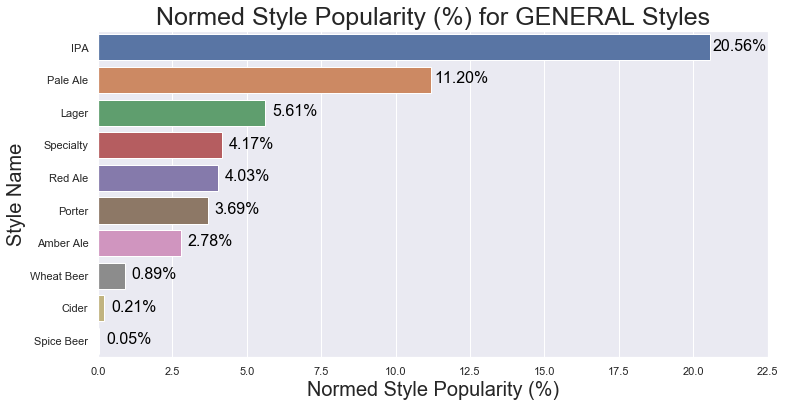

In [0]:
general_styles = ['Amber Ale','Pale Ale','Red Ale','Cider','Spice Beer',
                  'IPA','Lager','Specialty','Porter','Wheat Beer']
general_styles_dict = {'Brown':'Red','Fruit':'Spice', 'Stout':'Porter'}

df_general_styles = df.copy()
df_general_styles['Style_aux'] = 'Other'
for style in general_styles:
    df_general_styles.loc[df_general_styles['Style'].str.contains(style), 'Style_aux'] = style
for key in general_styles_dict:
    df_general_styles.loc[df_general_styles['Style'].str.contains('{} Ale'.format(key)), 'Style_aux'] = '{} Ale'.format(general_styles_dict[key])

df_general_styles = df_general_styles[df_general_styles['Style_aux']!='Other']
gb_style = df_general_styles.groupby(['Style_aux']).count().sort_values(['BeerID'], ascending=False).reset_index()[:20]
gb_style['BeerID'] = (gb_style['BeerID'] / len(df)) * 100

#theme
plt.figure(figsize=(12,6))
g=sns.barplot(x=gb_style['BeerID'], y=gb_style['Style_aux'], orient='h')
plt.title('Normed Style Popularity (%) for GENERAL Styles', fontsize=25)
plt.ylabel('Style Name', fontsize=20)
plt.xlabel('Normed Style Popularity (%)', fontsize=20)
plt.xlim(0,22.5)

for index, row in gb_style.iterrows():
    g.text(y=index+0.1,x=row['BeerID']+1,s='{:.2f}%'.format(row['BeerID']),
           color='black', ha="center", fontsize=16)

plt.show()

**Ta thấy 2 loại IPA và Plae ALe đạt trên 10%**

**Đặt biệt là IPA là loại phổ biến nhất với 20.56%**

# 4.Phân tích các cột hữu dụng

## a. Phân phối các cột OG, FG, ABV, IBU và Color

**Biểu đồ với thông số mặc định**

C:\huynd\Anaconda\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


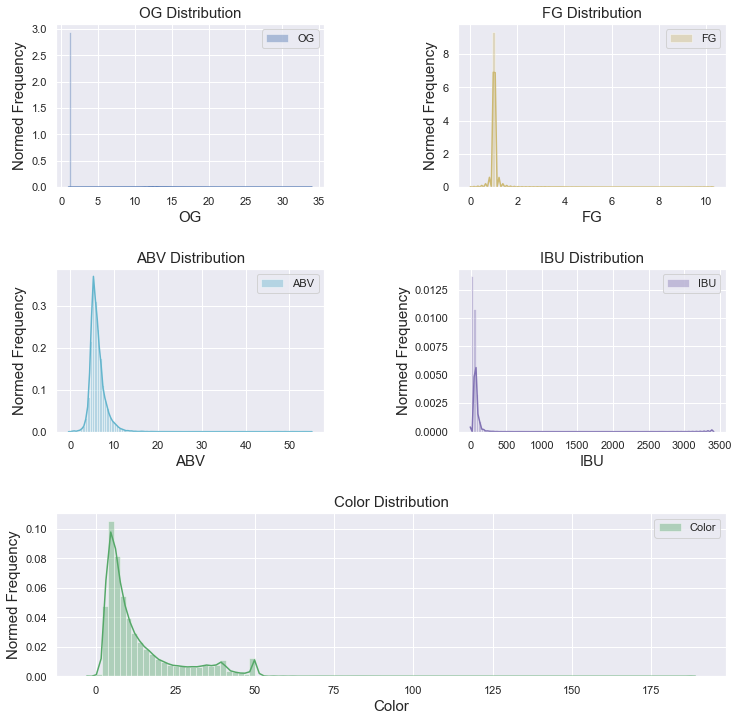

In [0]:
plt.figure(figsize=(12,12))
count=0
for col, color in zip(['OG', 'FG', 'ABV', 'IBU','Color'],['b','y','c','m','g']):
    count+=1
    if(count==5):
        plt.subplot(3,2,(5,6))
    else:
        plt.subplot(3,2,count)
    sns.distplot(df[col], bins=100, label=col, color=color)
    plt.title('{} Distribution'.format(col), fontsize=15)
    plt.legend()
    plt.ylabel('Normed Frequency', fontsize=15)
    plt.xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

--------------------------------------------------------------------------------------

**Biểu đồ với log(x+1)**

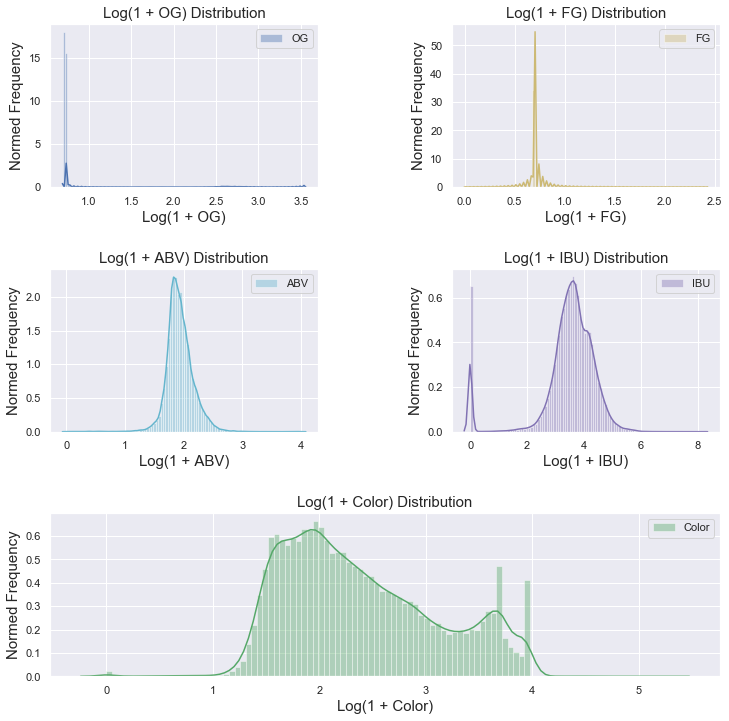

In [0]:
plt.figure(figsize=(12,12))
count=0
for col, color in zip(['OG', 'FG', 'ABV', 'IBU','Color'],['b','y','c','m','g']):
    count+=1
    if(count==5):
        plt.subplot(3,2,(5,6))
    else:
        plt.subplot(3,2,count)
    sns.distplot(np.log1p(df[col]), bins=100, label=col, color=color)
    plt.title('Log(1 + {}) Distribution'.format(col), fontsize=15)
    plt.legend()
    plt.ylabel('Normed Frequency', fontsize=15)
    plt.xlabel('Log(1 + {})'.format(col), fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

**ABV(Alcohol by volume)** *có phân phối tốt.*

**Color** *có phân phối tương tự như biểu đồ phân phối bình thường.*

*Nhưng có vẻ nó đã thoát khỏi giá trị tiêu cực.*

**IBU** *cho thấy có nhiều số 0 hơn sau khi biến đổi log.*

**Cần phân tích thêm.**

--------------------------------------------------------------------------------------

## b. ABV (Alcohol by volume)

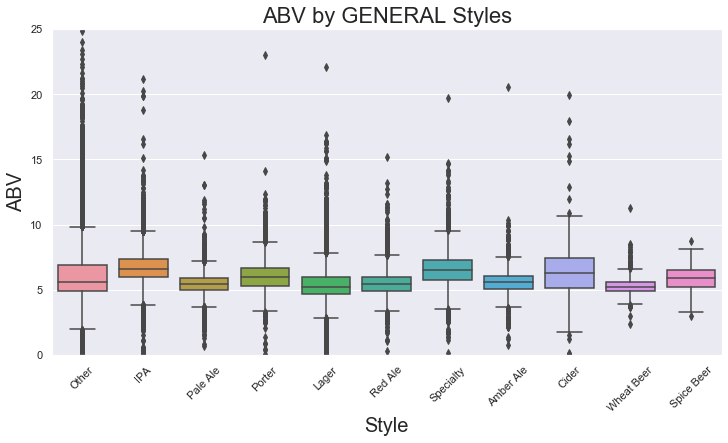

In [0]:
general_styles = ['Amber Ale','Pale Ale','Red Ale','Cider','Spice Beer',
                  'IPA','Lager','Specialty','Porter','Wheat Beer']
general_styles_dict = {'Brown':'Red','Fruit':'Spice', 'Stout':'Porter'}

df_general_styles = df.copy()
df_general_styles['Style_aux'] = 'Other'
for style in general_styles:
    df_general_styles.loc[df_general_styles['Style'].str.contains(style), 'Style_aux'] = style
for key in general_styles_dict:
    df_general_styles.loc[df_general_styles['Style'].str.contains('{} Ale'.format(key)), 'Style_aux'] = '{} Ale'.format(general_styles_dict[key])

plt.figure(figsize=(12,6))
sns.boxplot(df_general_styles['Style_aux'], df_general_styles['ABV'])
plt.xticks(rotation=45)
plt.ylim(0,25)
plt.title('ABV by GENERAL Styles', fontsize=22)
plt.xlabel('Style', fontsize=20)
plt.ylabel('ABV', fontsize=20)
plt.show()

## c. Color

**Biểu đồ mối liên hệ giữa Style và Color**

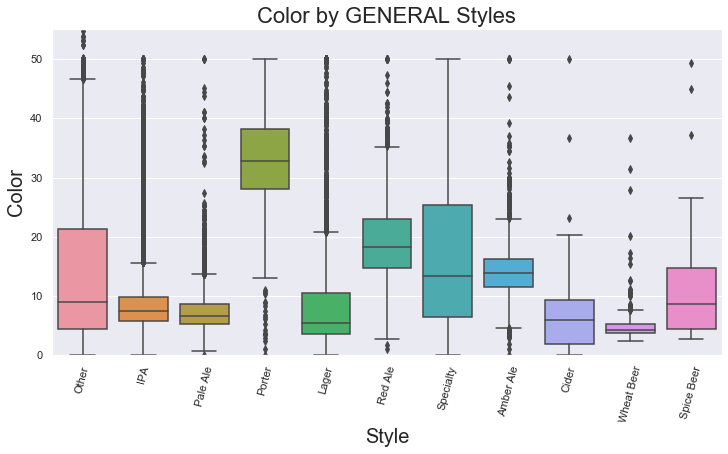

In [0]:
order = df_general_styles.groupby('Style_aux')['Color'].median().fillna(0).sort_values()[::-1].index

plt.figure(figsize=(12,6))
sns.boxplot(df_general_styles['Style_aux'], df_general_styles['Color'])
plt.xticks(rotation=75)
plt.ylim(0,55)
plt.title('Color by GENERAL Styles', fontsize=22)
plt.xlabel('Style', fontsize=20)
plt.ylabel('Color', fontsize=20)
plt.show()

**Ta thấy rằng Porter thật sự khó phân biệt bằng màu sắc so với các loại còn lại**

## d. Mối quan hệ giữa Color và ABV

C:\huynd\Anaconda\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


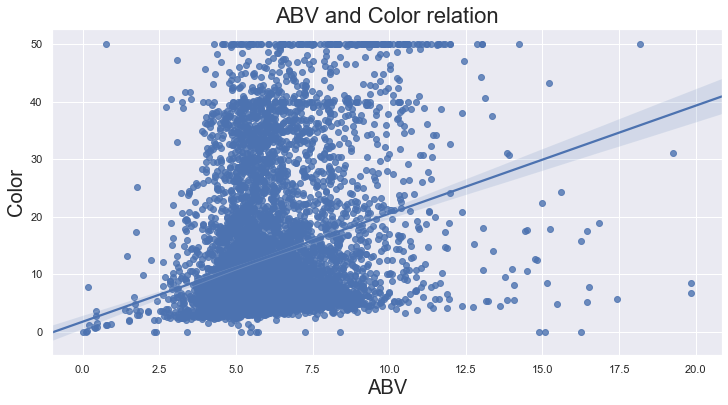

In [0]:
df_abv_color = df[(df['ABV']<=20) & (df['Color']<=50)]
df_abv_color = df_abv_color.sample(int(len(df_abv_color)/10), random_state=42)

plt.figure(figsize=(12,6))
sns.regplot(df_abv_color['ABV'],df_abv_color['Color'])
plt.title('ABV and Color relation', fontsize=22)
plt.xlabel('ABV', fontsize=20)
plt.ylabel('Color', fontsize=20)
plt.show();

*Ta thấy rằng khi* **đường hồi quy** 
*đi từ dưới trái tới trên phải ta có thể nói:* 
**các loại bia có nồng độ cồn cao thì màu sắc càng đậm** 
*(Nhưng đây không phải là xu hướng mạnh mẽ).*

## e. Các giá trị khác: OG, FG, IBU

C:\huynd\Anaconda\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\huynd\Anaconda\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\huynd\Anaconda\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional inde

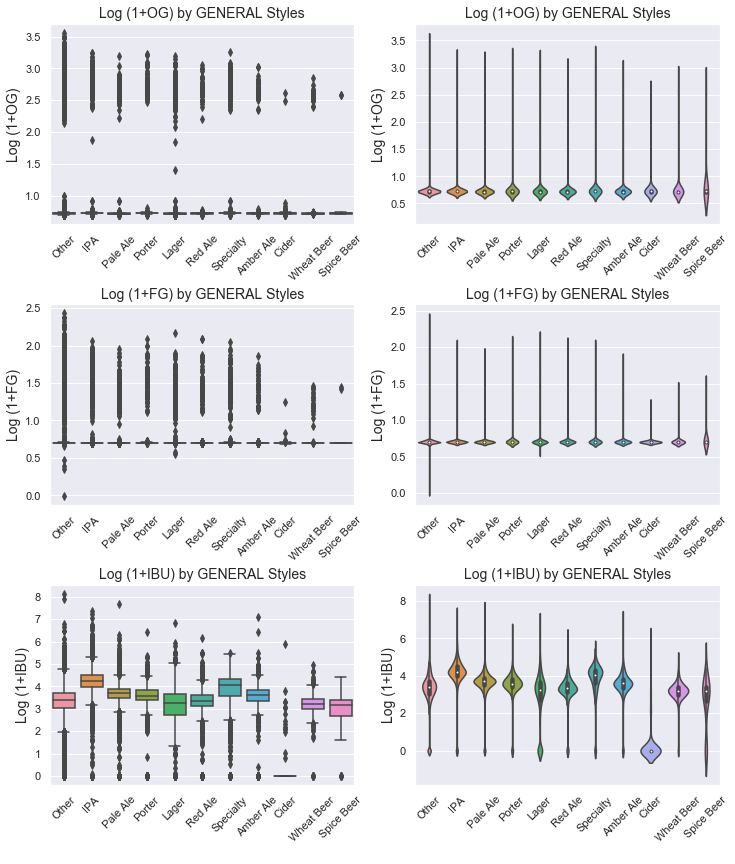

In [0]:
plt.figure(figsize=(12,14))
count=0    
for col in ['OG', 'FG', 'IBU']:
    for i in range(1,3):
        count+=1
        plt.subplot(3,2,count)

        if (i==1):
            sns.boxplot(df_general_styles['Style_aux'], np.log1p(df_general_styles[col]))
        else:
            sns.violinplot(df_general_styles['Style_aux'], np.log1p(df_general_styles[col]))
        plt.xticks(rotation=45)
        plt.title('Log (1+{}) by GENERAL Styles'.format(col), fontsize=14)
        plt.xlabel(' ')
        plt.ylabel('Log (1+{})'.format(col), fontsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show();

Các giá trị của **OF** và **FG** tập trung ở một điểm cụ thể. Việc này làm cho **Boxplot** trở nên vô dụng. Vì thế ta sử dụng **Violinplot** để thể hiện sự tập trung của biểu đồ

# 5. Phân loại

## a BrewMethod

No handles with labels found to put in legend.


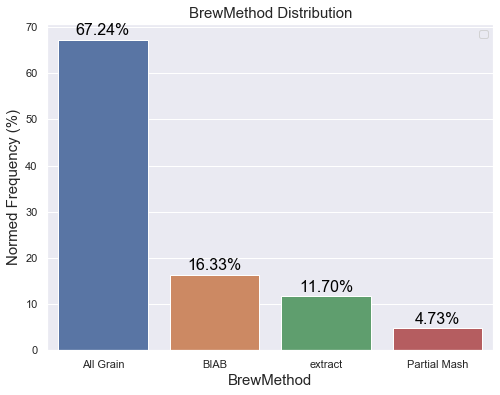

In [0]:
col= 'BrewMethod'
gb_brew_method = df.groupby([col]).count().sort_values(['BeerID'], ascending=False).reset_index()[:20]
gb_brew_method['BeerID'] = (gb_brew_method['BeerID'] / len(df)) * 100

plt.figure(figsize=(8,6))
g=sns.barplot(gb_brew_method[col], gb_brew_method['BeerID'])
plt.title('{} Distribution'.format(col), fontsize=15)
plt.legend()
plt.ylabel('Normed Frequency (%)', fontsize=15)
plt.xlabel(col, fontsize=15)

for index, row in gb_brew_method.iterrows():
    g.text(x=index,y=row['BeerID']+1,s='{:.2f}%'.format(row['BeerID']), 
           color='black', ha="center", fontsize=16)

plt.show()

## b. SugarScale

No handles with labels found to put in legend.


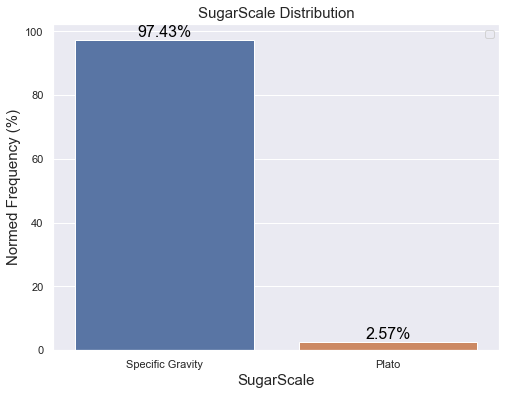

In [0]:
col = 'SugarScale'
gb_brew_method = df.groupby([col]).count().sort_values(['BeerID'], ascending=False).reset_index()[:20]
gb_brew_method['BeerID'] = (gb_brew_method['BeerID'] / len(df)) * 100

plt.figure(figsize=(8,6))
g=sns.barplot(gb_brew_method[col], gb_brew_method['BeerID'])
plt.title('{} Distribution'.format(col), fontsize=15)
plt.legend()
plt.ylabel('Normed Frequency (%)', fontsize=15)
plt.xlabel(col, fontsize=15)

for index, row in gb_brew_method.iterrows():
    g.text(x=index,y=row['BeerID']+1,s='{:.2f}%'.format(row['BeerID']), 
           color='black', ha="center", fontsize=16)

plt.show()
